In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders
!pip install optuna
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
from matplotlib.ticker import FixedLocator
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import mode
from scipy import stats
from category_encoders import CatBoostEncoder
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

<ipython-input-4-c42ad7b9f4e5>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/train.csv')


In [5]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
df.shape

(100000, 28)

In [7]:
colunas_com_underline = df.applymap(lambda x: '_' in str(x)).any()
colunas_com_underline = colunas_com_underline[colunas_com_underline].index.tolist()
colunas_com_underline

['Customer_ID',
 'Age',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [8]:
for coluna in colunas_com_underline:
    print("Coluna:", coluna)
    strings_com_underline = df[coluna].fillna('').loc[df[coluna].str.contains('_').fillna(False)].head()
    print(strings_com_underline)
    print()

Coluna: Customer_ID
0    CUS_0xd40
1    CUS_0xd40
2    CUS_0xd40
3    CUS_0xd40
4    CUS_0xd40
Name: Customer_ID, dtype: object

Coluna: Age
8     28_
54    34_
58    30_
71    24_
89    33_
Name: Age, dtype: object

Coluna: Occupation
8     _______
16    _______
18    _______
20    _______
29    _______
Name: Occupation, dtype: object

Coluna: Annual_Income
10     34847.84_
27     30689.89_
32     35547.71_
56     34081.38_
66    114838.41_
Name: Annual_Income, dtype: object

Coluna: Num_of_Loan
37     0_
80     3_
84     3_
94     2_
119    5_
Name: Num_of_Loan, dtype: object

Coluna: Num_of_Delayed_Payment
6       8_
11      3_
53      3_
54      2_
119    13_
Name: Num_of_Delayed_Payment, dtype: object

Coluna: Changed_Credit_Limit
2      _
65     _
66     _
109    _
110    _
Name: Changed_Credit_Limit, dtype: object

Coluna: Credit_Mix
0     _
10    _
19    _
29    _
35    _
Name: Credit_Mix, dtype: object

Coluna: Outstanding_Debt
87     1328.93_
142    1283.37_
368    2797.17_
6

In [9]:
colunas_com_underline.remove('Customer_ID')
colunas_com_underline.remove('Payment_Behaviour')

In [10]:
def remover_(df, colunas):
    for coluna in colunas:
      df[coluna] = df[coluna].str.replace('_', '')
    return df


In [11]:
df = remover_(df,colunas_com_underline)

In [12]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


* ID: Representa uma identificação única de uma entrada.
* Customer_ID: Representa uma identificação única de uma pessoa.
* Month: Representa o mês do ano.
* Name: Representa o nome de uma pessoa.
* Age: Representa a idade da pessoa.
* SSN: Representa o número de Seguro Social de uma pessoa.
* Occupation: Representa a ocupação da pessoa.
* Annual_Income: Representa a renda anual da pessoa.
* Monthly_Inhand_Salary: Representa o salário mensal líquido de uma pessoa.
* Num_Bank_Accounts: Representa o número de contas bancárias que uma pessoa possui.
* Num_Credit_Card: Representa o número de outros cartões de crédito detidos por uma pessoa.
* Interest_Rate: Representa a taxa de juros no cartão de crédito.
* Num_of_Loan: Representa o número de empréstimos concedidos pelo banco.
* Type_of_Loan: Representa os tipos de empréstimo concedidos a uma pessoa.
* Delay_from_due_date: Representa o número médio de dias de atraso a partir da data de vencimento.
* Num_of_Delayed_Payment: Representa o número médio de pagamentos atrasados por uma pessoa.
* Changed_Credit_Limit: Representa a alteração percentual no limite do cartão de crédito.
* Num_Credit_Inquiries: Representa o número de consultas de crédito.
* Credit_Mix: Representa a classificação da mistura de créditos.
* Outstanding_Debt: Representa a dívida pendente a ser paga (em USD).
* Credit_Utilization_Ratio: Representa a taxa de utilização do cartão de crédito.
* Credit_History_Age: Representa a idade do histórico de crédito da pessoa.
* Payment_of_Min_Amount: Representa se apenas o valor mínimo foi pago pela pessoa.
* Total_EMI_per_month: Representa os pagamentos mensais de EMI (em USD).
* Amount_invested_monthly: Representa o valor investido mensalmente pelo cliente (em USD).
* Payment_Behaviour: Representa o comportamento de pagamento do cliente (em USD).
* Monthly_Balance: Representa o saldo mensal do cliente (em USD).
* Credit_Score: Representa o intervalo de pontuação de crédito (Pobre, Padrão, Bom).

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Existem várias colunas que estão com tipo errado, vamos ajustar

In [14]:
df['Age'] = df['Age'].astype(int)
df['Annual_Income'] = df['Annual_Income'].astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce')
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')

In [15]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,9.713200e+04
mean,110.649700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,1403.118217,637.412998,-3.088580e+22
std,686.244717,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8306.041270,2043.319327,3.208492e+24
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,-3.333333e+26
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,74.534002,2.699858e+02
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,135.925682,3.364493e+02
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,265.731733,4.696405e+02
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1.602041e+03


In [16]:
analise_cols = []

for column in df.columns:
    tipo_variavel = df[column].dtype
    qtd_nulos = df[column].isnull().sum()
    pct_nulos = round((qtd_nulos / len(df)) * 100, 2)
    cardinalidade = df[column].nunique()

    analise_cols.append([column, tipo_variavel, qtd_nulos, pct_nulos, cardinalidade])

summary_df = pd.DataFrame(analise_cols, columns=['Coluna', 'Tipo Variável', 'Valores Nulos', 'Porcentagem de Nulos (%)', 'Valores Únicos'])

summary_df

,Coluna,Tipo Variável,Valores Nulos,Porcentagem de Nulos (%),Valores Únicos
0,ID,object,0,0.00,100000
1,Customer_ID,object,0,0.00,12500
2,Month,object,0,0.00,8
3,Name,object,9985,9.98,10139
4,Age,int64,0,0.00,1728
5,SSN,object,0,0.00,12501
6,Occupation,object,0,0.00,16
7,Annual_Income,float64,0,0.00,13487
8,Monthly_Inhand_Salary,float64,15002,15.00,13235
9,Num_Bank_Accounts,int64,0,0.00,943


Existem vários erros de preenchimento e muitas colunas com valores negativos que não deveriam existir, como podemos ter vários registros de uma mesma pessoa, vamos tentar corrigir esses erros

In [17]:
def ajustar_idade(grupo):
    moda = grupo['Age'].mode().iloc[0]
    min_value = grupo['Age'].min()
    max_value = grupo['Age'].max()

    if pd.isna(min_value) or pd.isna(max_value):
        grupo['Age'] = grupo['Age'].fillna(moda)
    elif moda - min_value > 1:
        grupo['Age'] = moda
    elif max_value - moda > 1:
        grupo['Age'] = moda

    return grupo

In [18]:
df = df.groupby('Customer_ID', group_keys=False).apply(ajustar_idade)

In [19]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


In [20]:
for col in df.select_dtypes(include=['number']).columns:
  qtd_negativos = (df[col] < 0).sum()
  if qtd_negativos > 0:
    print(col)
    print(qtd_negativos)

Num_Bank_Accounts
21
Num_of_Loan
3876
Delay_from_due_date
591
Num_of_Delayed_Payment
644
Changed_Credit_Limit
1586
Monthly_Balance
9


Analisando as colunas com valores negativos, número de contas, número de empréstimos e número de pagamentos atrasados não podem ser negativas, as outras como não temos informações, a princípio iremos manter esses valores

In [21]:
cols_negativas = ['Num_Bank_Accounts','Num_of_Loan','Num_of_Delayed_Payment']

In [22]:
def substitui_negativo(df, columns):
    for col in columns:
        if col in df.columns:
            # Calcula a moda para cada Customer_ID para valores não-negativos
            moda_por_cliente = df[df[col] >= 0].groupby('Customer_ID')[col].agg(lambda x: mode(x)[0] if len(x) > 0 else 0)
            # Substitui valores negativos pela moda correspondente
            for customer_id in moda_por_cliente.index:
                moda = moda_por_cliente[customer_id]
                df.loc[(df['Customer_ID'] == customer_id) & (df[col] < 0), col] = moda
    return df

In [23]:
df_final = substitui_negativo(df,cols_negativas)

In [24]:
df_final['Type_of_Loan'] = df_final['Type_of_Loan'].fillna('')

In [25]:
all_types = set()
for items in df_final['Type_of_Loan']:
    items_clean = items.replace(' and ', ',').replace(', ', ',').replace(' ,', ',')
    for item in items_clean.split(','):
        all_types.add(item.strip())

for loan_type in all_types:
    df_final[loan_type] = 0

for index, row in df.iterrows():
    items_clean = row['Type_of_Loan'].replace(' and ', ',').replace(', ', ',').replace(' ,', ',')
    if items_clean:
      for loan_type in all_types:
          if loan_type in items_clean.split(','):
              df.at[index, loan_type] = 1


In [26]:
scores = {
    'Poor': 0,
    'Standard': 1,
    'Good': 1
}

df_final['Credit_Score'] = df_final['Credit_Score'].replace(scores)

In [27]:
df_final['Credit_Score'].value_counts()

Credit_Score
1    71002
0    28998
Name: count, dtype: int64

In [28]:
df_final.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,,Home Equity Loan,Personal Loan,Mortgage Loan,Payday Loan,Not Specified,Student Loan,Credit-Builder Loan,Auto Loan,Debt Consolidation Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,1,1,1,1,0,0,0,0,1,1,0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,1,1,1,1,0,0,0,0,1,1,0
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,1,1,1,1,0,0,0,0,1,1,0
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,1,1,1,1,0,0,0,0,1,1,0
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,1,1,1,1,0,0,0,0,1,1,0


## Análise dos Dados

In [29]:
sns.set_theme(style="darkgrid")

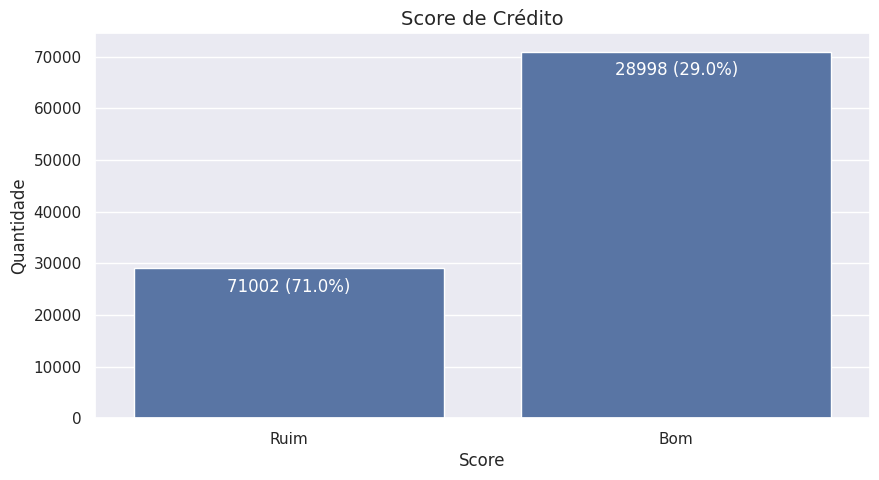

In [30]:
total = len(df_final['Credit_Score'])
counts = df_final['Credit_Score'].value_counts()

plt.figure(figsize=(10,5))
fig = sns.countplot(data = df_final, x='Credit_Score')
fig.set_title('Score de Crédito', fontsize=14)
fig.set_xlabel('Score', fontsize=12)
fig.set_ylabel('Quantidade', fontsize=12)
labels = [f"{v} ({v/total:.1%})" for v in counts]
fig.bar_label(fig.containers[0], labels=labels, padding=-20, color='white', fontsize=12)
fig.xaxis.set_major_locator(FixedLocator([0, 1]))
fig.set_xticklabels(['Ruim', 'Bom'])
plt.show()

## Modelagem de Dados

In [31]:
X = df_final.drop(['ID','Customer_ID','Name','SSN','Type_of_Loan','Credit_Score'], axis=1)
y = df_final['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

k = 5
threshold = 0.5
folds = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 32), (30000, 32), (70000,), (30000,))

In [33]:
modelos = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = []

In [34]:
for modelo_nome, modelo in modelos.items():
  for fold, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):
      X_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
      X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]

      cat_imputer = SimpleImputer(strategy='most_frequent')

      num_imputer = SimpleImputer(strategy='median')

      cat_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', CatBoostEncoder())])
      num_pipeline = Pipeline([('imputer', num_imputer)])

      # Identificando as variáveis categóricas e numéricas
      cat_cols = X_train_fold.select_dtypes(include=['object']).columns
      num_cols = X_train_fold.select_dtypes(exclude=['object']).columns

      # Criando um pré-processador para aplicar os pipelines às colunas apropriadas
      preprocessor = ColumnTransformer(
          transformers=[
              ('num', num_pipeline, num_cols),
              ('cat', cat_pipeline, cat_cols)
          ])

      # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
      X_train_processed = preprocessor.fit_transform(X_train_fold, y_train_fold)

      # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
      X_test_processed = preprocessor.transform(X_test_fold)

      # Treinando o modelo
      modelo.fit(X_train_processed, y_train_fold)

      # Obtendo as probabilidades relacionadas à classe 1
      y_pred_proba_train = modelo.predict_proba(X_train_processed)[:, 1]
      y_pred_proba = modelo.predict_proba(X_test_processed)[:, 1]

      # Obtendo as previsões do modelo
      y_pred = np.where(y_pred_proba > threshold, 1, 0)

      # Calculando as métricas
      precision = precision_score(y_test_fold, y_pred, zero_division=1)
      recall = recall_score(y_test_fold, y_pred)
      f1 = f1_score(y_test_fold, y_pred)

      precision_recall_curve_values = precision_recall_curve(y_test_fold, y_pred_proba)
      precision_recall_auc = auc(precision_recall_curve_values[1], precision_recall_curve_values[0])

      roc_auc = roc_auc_score(y_test_fold, y_pred_proba)

      result_dict = {
        'Modelo': modelo_nome,
        'Fold': fold,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Precision_Recall_AUC': precision_recall_auc,
        'ROC_AUC': roc_auc
        }

      results.append(result_dict)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr

In [35]:
results_df = pd.concat([pd.DataFrame([result]) for result in results], ignore_index=True)
results_df.head(5)

,Modelo,Fold,Precision,Recall,F1,Precision_Recall_AUC,ROC_AUC
0,Decision Tree,0,0.843680,0.833048,0.838330,0.897507,0.728947
1,Decision Tree,1,0.851006,0.856174,0.853582,0.904340,0.748354
2,Decision Tree,2,0.838486,0.815713,0.826943,0.892528,0.715444
3,Decision Tree,3,0.852267,0.834592,0.843337,0.902108,0.740630
4,Decision Tree,4,0.844353,0.827947,0.836070,0.897186,0.727595


In [36]:
results_df.groupby('Modelo')[['Precision','Recall','F1','Precision_Recall_AUC','ROC_AUC']].mean()

,Precision,Recall,F1,Precision_Recall_AUC,ROC_AUC
Modelo,,,,,
Decision Tree,0.845958,0.833495,0.839652,0.898734,0.732194
Gradient Boosting,0.853249,0.911728,0.881514,0.935127,0.866420
Logistic Regression,1.000000,0.000000,0.000000,0.854329,0.500000
Random Forest,0.889411,0.917129,0.903054,0.960812,0.913133
XGBoost,0.878350,0.906228,0.892061,0.952574,0.895463


In [37]:
cat_imputer = SimpleImputer(strategy='most_frequent')

num_imputer = SimpleImputer(strategy='median')

cat_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', CatBoostEncoder())])
num_pipeline = Pipeline([('imputer', num_imputer)])

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(random_state=42))])

In [38]:
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    min_samples_split = trial.suggest_int('min_samples_split', 2,10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 200)

    model_pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__max_depth=max_depth,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__max_leaf_nodes=max_leaf_nodes
    )

    score = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring=roc_auc_scorer, n_jobs=-1).mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-04-15 21:49:56,364] A new study created in memory with name: no-name-e4f68da3-3f06-4c9a-abab-f8f27a9bdf99
[I 2024-04-15 21:51:23,923] Trial 0 finished with value: 0.869007330776418 and parameters: {'n_estimators': 116, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 9, 'max_leaf_nodes': 176}. Best is trial 0 with value: 0.869007330776418.
[I 2024-04-15 21:54:03,423] Trial 1 finished with value: 0.8466477166752773 and parameters: {'n_estimators': 397, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7, 'max_leaf_nodes': 112}. Best is trial 0 with value: 0.869007330776418.
[I 2024-04-15 21:55:48,396] Trial 2 finished with value: 0.8643501053296868 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'max_leaf_nodes': 95}. Best is trial 0 with value: 0.869007330776418.
[I 2024-04-15 21:56:47,499] Trial 3 finished with value: 0.7663662903643174 and parameters: {'n_estimators': 496, 'max_depth': 1, 'min_samples_

In [39]:
best_params = study.best_params
print(best_params)

{'n_estimators': 116, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 9, 'max_leaf_nodes': 176}


In [40]:
model_pipeline.set_params(
    classifier__n_estimators=best_params['n_estimators'],
    classifier__max_depth=best_params['max_depth'],
    classifier__min_samples_leaf=best_params['min_samples_leaf'],
    classifier__min_samples_split=best_params['min_samples_split'],
    classifier__max_leaf_nodes=best_params['max_leaf_nodes']
)

model_pipeline.fit(X_train, y_train)


y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8525666101621245
Recall: 0.9208487864419511
F1-score: 0.8853931569919653


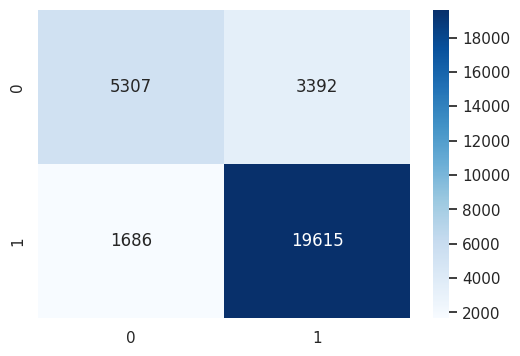

In [42]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

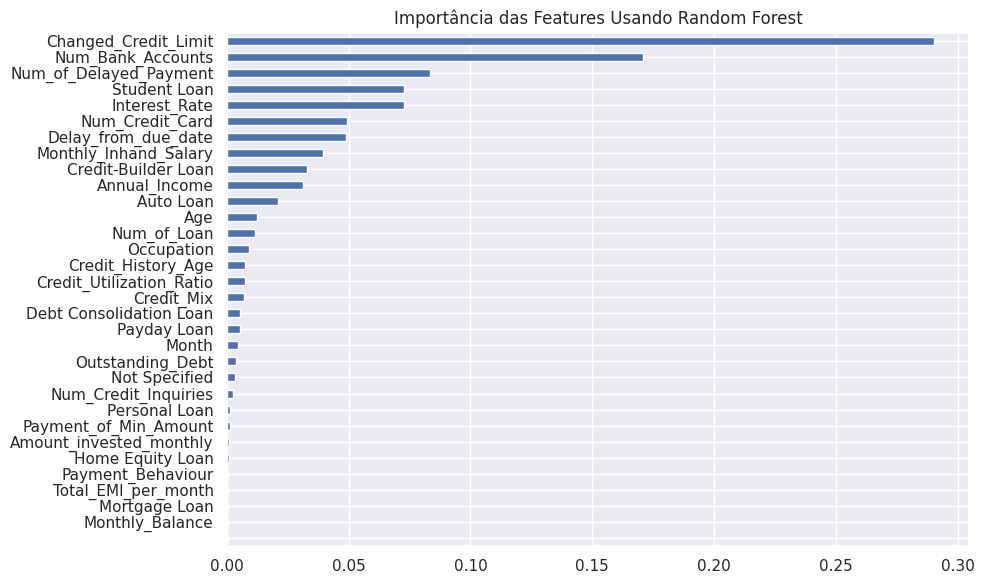

In [43]:
importances = pd.Series(model_pipeline.named_steps['classifier'].feature_importances_, index = X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
ax = importances.plot.barh()
ax.set_title("Importância das Features Usando Random Forest")
ax.figure.tight_layout()